In [1]:
# Import tensorflow and additional libraries
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio
#pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.express as px

# Check version
print('torch version: ', torch.__version__)

torch version:  1.10.0+cu111


In [2]:
data_dir = './data'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



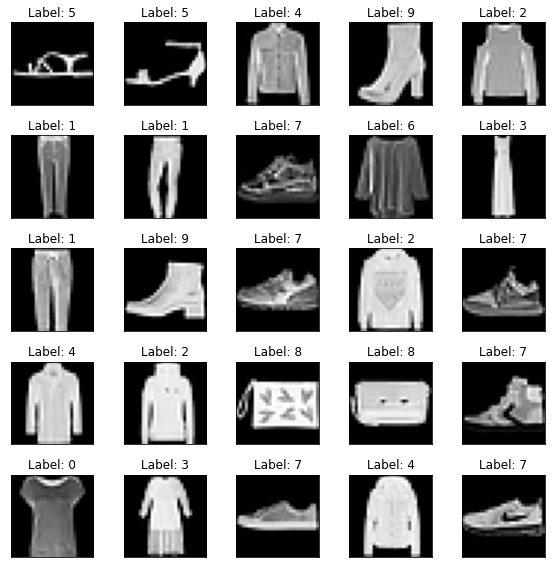

In [3]:
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [5]:
m = len(train_dataset)

# random_split randomly split a dataset into non-overlapping new datasets of given lengths
# train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size = 16

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


In [10]:
# Define blocks
from torch.nn.parameter import Parameter

class channel_attention(nn.Module):    
    def __init__(self, channel, scale_factor=4):
        super(channel_attention, self).__init__()
        self.GAP = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//scale_factor, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel//scale_factor, channel, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.GAP(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        
        return x * y.expand_as(x)

    
class spatial_attention(nn.Module):   
    def __init__(self, channel):
        super(spatial_attention, self).__init__()
        self.conv = nn.Conv2d(channel, 1, kernel_size=3, padding='same', bias=False)
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x):
        y = self.conv(x)
        y = self.sigmoid(y)
    
        return x * y.expand_as(x)
    
    
class parallel_CASA_add_attention(nn.Module):   
    def __init__(self, channel, scale_factor):
        super(parallel_CASA_add_attention, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
        y = y1 + y2
    
        return x * y.expand_as(x)
    
    
class parallel_CASA_mul_attention(nn.Module):   
    def __init__(self, channel, scale_factor):
        super(parallel_CASA_mul_attention, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
        y = y1 * y2
    
        return x * y.expand_as(x)
    
    
class serial_CA(nn.Module):
    def __init__(self, channel, scale_factor):
        super(serial_CA, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
        
    def forward(self, x):
        y = self.CA(x)
        y = self.SA(y)
    
        return x * y.expand_as(x)
    
    
class serial_SA(nn.Module):
    def __init__(self, channel, scale_factor):
        super(serial_SA, self).__init__()
        self.CA = channel_attention(channel, scale_factor)
        self.SA = spatial_attention(channel)
        
    def forward(self, x):
        y = self.SA(x)
        y = self.CA(y)
    
        return x * y.expand_as(x)
    
    
class attention_module(nn.Module):
    def __init__(self, channel, attention_type=None, scale_factor=None):
        super(attention_module, self).__init__()
        
        if attention_type == 'channel':
            # Channel Attnetion only
            self.attention_layer = channel_attention(channel, scale_factor)
        
        elif attention_type == 'spatial':
            # Spatial Attention only
            self.attention_layer = spatial_attention(channel)
        
        elif attention_type == 'parellel_add':
            # Parelle Attention (Add)
            self.attention_layer = parallel_CASA_add_attention(channel, scale_factor)

        elif attention_type == 'parellel_mul':
            # Parelle Attention (Mul)
            self.attention_layer = parallel_CASA_mul_attention(channel, scale_factor)

        elif attention_type == 'serial_ca':
            # Serial Attention, CA first
            self.attention_layer = serial_CA(channel, scale_factor)

        elif attention_type == 'serial_sa':
            # Serial Attention, SA first
            self.attention_layer = serial_SA(channel, scale_factor)

        elif attention_type == None and scale_factor==None:
            self.attention_layer = None
            
        else:
            self.attention_layer = None
    
    def forward(self, x):
        if self.attention_layer != None:
            out = self.attention_layer(x)
        else:
            out = x
        
        return out


class res_block(nn.Module):
    def __init__(self, input_dim, output_dim, stride):
        super(res_block, self).__init__()
        self.stride = stride
        self.input_layer = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride),
            nn.BatchNorm2d(output_dim)
        )
        self.res_layer = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=1, stride=stride),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_dim, output_dim, kernel_size=1, stride=1, padding='same'),
            nn.BatchNorm2d(output_dim),    
        )
        self.relu = nn.ReLU()
                
    def forward(self, x):
        residual = x
        if self.stride != 1:
            residual = self.input_layer(x)
        out = self.res_layer(x)
        out += residual
        out = self.relu(out)
        
        return out

In [11]:
class ResNet(nn.Module):
    def __init__(self, attention_type=None, scale_factor=None, num_classes=10):
        super().__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=(7-1)//2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=(3-1)//2),
            res_block(input_dim=64, output_dim=64, stride=2),
            attention_module(64, attention_type, scale_factor),
            res_block(input_dim=64, output_dim=64, stride=1),
            attention_module(64, attention_type, scale_factor),
            res_block(input_dim=64, output_dim=128, stride=2),
            attention_module(128, attention_type, scale_factor),
            res_block(input_dim=128, output_dim=128, stride=1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.resnet(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.softmax(out)
        
        return out

In [12]:
### Set the random seed for reproducible results
torch.manual_seed(42)

model_normal = ResNet()
model_channel = ResNet(attention_type='channel', scale_factor=4)
model_spatial = ResNet(attention_type='spatial')
model_parellel_add = ResNet(attention_type='parellel_add', scale_factor=4)
model_parellel_mul = ResNet(attention_type='parellel_mul', scale_factor=4)
model_serial_ca = ResNet(attention_type='serial_ca', scale_factor=4)
model_serial_sa = ResNet(attention_type='serial_sa', scale_factor=4)

In [13]:
import torchsummary
torchsummary.summary(model_normal, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
 attention_module-14             [-1, 6

In [14]:
torchsummary.summary(model_channel, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-14             [-1, 6

In [15]:
torchsummary.summary(model_spatial, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
           Conv2d-14              [-1, 

In [16]:
torchsummary.summary(model_parellel_add, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-14             [-1, 6

In [17]:
torchsummary.summary(model_parellel_mul, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-14             [-1, 6

In [18]:
torchsummary.summary(model_serial_ca, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
AdaptiveAvgPool2d-14             [-1, 6

In [19]:
torchsummary.summary(model_serial_sa, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,200
              ReLU-2           [-1, 64, 14, 14]               0
       BatchNorm2d-3           [-1, 64, 14, 14]             128
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 4, 4]           4,160
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Conv2d-7             [-1, 64, 4, 4]           4,160
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10             [-1, 64, 4, 4]           4,160
      BatchNorm2d-11             [-1, 64, 4, 4]             128
             ReLU-12             [-1, 64, 4, 4]               0
        res_block-13             [-1, 64, 4, 4]               0
           Conv2d-14              [-1, 

In [20]:
### Define the loss function
criterion = torch.nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 0.001

optim1 = torch.optim.Adam(model_normal.parameters(), lr=lr, weight_decay=1e-05)
optim2 = torch.optim.Adam(model_channel.parameters(), lr=lr, weight_decay=1e-05)
optim3 = torch.optim.Adam(model_spatial.parameters(), lr=lr, weight_decay=1e-05)
optim4 = torch.optim.Adam(model_parellel_add.parameters(), lr=lr, weight_decay=1e-05)
optim5 = torch.optim.Adam(model_parellel_mul.parameters(), lr=lr, weight_decay=1e-05)
optim6 = torch.optim.Adam(model_serial_ca.parameters(), lr=lr, weight_decay=1e-05)
optim7 = torch.optim.Adam(model_serial_sa.parameters(), lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move both the encoder and the decoder to the selected device
model_normal = model_normal.to(device)
model_channel = model_channel.to(device)
model_spatial = model_spatial.to(device)
model_parellel_add = model_parellel_add.to(device)
model_parellel_mul = model_parellel_mul.to(device)
model_serial_ca = model_serial_ca.to(device)
model_serial_sa = model_serial_sa.to(device)

# EPOCHS
EPOCHS = 30

In [21]:
model_normal_train_loss = []
model_normal_val_loss = []
model_normal_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_normal.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_normal(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim1.zero_grad()
        loss.backward()
        optim1.step()
        
    # evaluate
    model_normal.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_normal(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_normal_train_loss.append(train_loss)
    model_normal_val_loss.append(val_loss)
    model_normal_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.1080     train_accuracy : 0.7399     val_loss : 0.1057     val_accuracy : 0.7703
epoch 2 :  train_loss : 0.1054     train_accuracy : 0.7753     val_loss : 0.1041     val_accuracy : 0.7957
epoch 3 :  train_loss : 0.1038     train_accuracy : 0.8005     val_loss : 0.1040     val_accuracy : 0.7965
epoch 4 :  train_loss : 0.1031     train_accuracy : 0.8126     val_loss : 0.1029     val_accuracy : 0.8139
epoch 5 :  train_loss : 0.1026     train_accuracy : 0.8195     val_loss : 0.1031     val_accuracy : 0.8122
epoch 6 :  train_loss : 0.1023     train_accuracy : 0.8248     val_loss : 0.1030     val_accuracy : 0.8132
epoch 7 :  train_loss : 0.1022     train_accuracy : 0.8257     val_loss : 0.1021     val_accuracy : 0.8277
epoch 8 :  train_loss : 0.1019     train_accuracy : 0.8299     val_loss : 0.1021     val_accuracy : 0.8260
epoch 9 :  train_loss : 0.1017     train_accuracy : 0.8335     val_loss : 0.1028     val_accuracy : 0.8152
epoch 10 :  train_loss : 0.1017     t

In [22]:
model_channel_train_loss = []
model_channel_val_loss = []
model_channel_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_channel.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_channel(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim2.zero_grad()
        loss.backward()
        optim2.step()
        
    # evaluate
    model_channel.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_channel(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_channel_train_loss.append(train_loss)
    model_channel_val_loss.append(val_loss)
    model_channel_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.1072     train_accuracy : 0.7530     val_loss : 0.1048     val_accuracy : 0.7853
epoch 2 :  train_loss : 0.1035     train_accuracy : 0.8069     val_loss : 0.1022     val_accuracy : 0.8259
epoch 3 :  train_loss : 0.1023     train_accuracy : 0.8239     val_loss : 0.1027     val_accuracy : 0.8157
epoch 4 :  train_loss : 0.1017     train_accuracy : 0.8346     val_loss : 0.1011     val_accuracy : 0.8426
epoch 5 :  train_loss : 0.1013     train_accuracy : 0.8399     val_loss : 0.1016     val_accuracy : 0.8366
epoch 6 :  train_loss : 0.1009     train_accuracy : 0.8478     val_loss : 0.1015     val_accuracy : 0.8363
epoch 7 :  train_loss : 0.1006     train_accuracy : 0.8510     val_loss : 0.1005     val_accuracy : 0.8531
epoch 8 :  train_loss : 0.1003     train_accuracy : 0.8563     val_loss : 0.1009     val_accuracy : 0.8457
epoch 9 :  train_loss : 0.1002     train_accuracy : 0.8585     val_loss : 0.1003     val_accuracy : 0.8565
epoch 10 :  train_loss : 0.0999     t

In [23]:
model_spatial_train_loss = []
model_spatial_val_loss = []
model_spatial_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_spatial.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_spatial(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim3.zero_grad()
        loss.backward()
        optim3.step()
        
    # evaluate
    model_spatial.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_spatial(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_spatial_train_loss.append(train_loss)
    model_spatial_val_loss.append(val_loss)
    model_spatial_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.1061     train_accuracy : 0.7711     val_loss : 0.1028     val_accuracy : 0.8168
epoch 2 :  train_loss : 0.1029     train_accuracy : 0.8163     val_loss : 0.1030     val_accuracy : 0.8128
epoch 3 :  train_loss : 0.1021     train_accuracy : 0.8274     val_loss : 0.1031     val_accuracy : 0.8101
epoch 4 :  train_loss : 0.1019     train_accuracy : 0.8318     val_loss : 0.1016     val_accuracy : 0.8364
epoch 5 :  train_loss : 0.1017     train_accuracy : 0.8351     val_loss : 0.1023     val_accuracy : 0.8232
epoch 6 :  train_loss : 0.1013     train_accuracy : 0.8404     val_loss : 0.1021     val_accuracy : 0.8276
epoch 7 :  train_loss : 0.1010     train_accuracy : 0.8441     val_loss : 0.1012     val_accuracy : 0.8402
epoch 8 :  train_loss : 0.1008     train_accuracy : 0.8490     val_loss : 0.1010     val_accuracy : 0.8445
epoch 9 :  train_loss : 0.1007     train_accuracy : 0.8497     val_loss : 0.1010     val_accuracy : 0.8440
epoch 10 :  train_loss : 0.1005     t

In [24]:
model_parellel_add_train_loss = []
model_parellel_add_val_loss = []
model_parellel_add_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_parellel_add.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_parellel_add(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim4.zero_grad()
        loss.backward()
        optim4.step()
        
    # evaluate
    model_parellel_add.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_parellel_add(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_parellel_add_train_loss.append(train_loss)
    model_parellel_add_val_loss.append(val_loss)
    model_parellel_add_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.1093     train_accuracy : 0.7146     val_loss : 0.1051     val_accuracy : 0.7775
epoch 2 :  train_loss : 0.1050     train_accuracy : 0.7804     val_loss : 0.1046     val_accuracy : 0.7881
epoch 3 :  train_loss : 0.1039     train_accuracy : 0.7978     val_loss : 0.1040     val_accuracy : 0.7970
epoch 4 :  train_loss : 0.1034     train_accuracy : 0.8057     val_loss : 0.1028     val_accuracy : 0.8158
epoch 5 :  train_loss : 0.1029     train_accuracy : 0.8133     val_loss : 0.1028     val_accuracy : 0.8164
epoch 6 :  train_loss : 0.1027     train_accuracy : 0.8169     val_loss : 0.1028     val_accuracy : 0.8154
epoch 7 :  train_loss : 0.1035     train_accuracy : 0.8051     val_loss : 0.1047     val_accuracy : 0.7856
epoch 8 :  train_loss : 0.1020     train_accuracy : 0.8282     val_loss : 0.1024     val_accuracy : 0.8227
epoch 9 :  train_loss : 0.1020     train_accuracy : 0.8291     val_loss : 0.1028     val_accuracy : 0.8149
epoch 10 :  train_loss : 0.1017     t

In [25]:
model_parellel_mul_train_loss = []
model_parellel_mul_val_loss = []
model_parellel_mul_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_parellel_mul.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_parellel_mul(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim5.zero_grad()
        loss.backward()
        optim5.step()
        
    # evaluate
    model_parellel_mul.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_parellel_mul(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_parellel_mul_train_loss.append(train_loss)
    model_parellel_mul_val_loss.append(val_loss)
    model_parellel_mul_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.1285     train_accuracy : 0.3930     val_loss : 0.1316     val_accuracy : 0.3399
epoch 2 :  train_loss : 0.1161     train_accuracy : 0.6036     val_loss : 0.1181     val_accuracy : 0.5715
epoch 3 :  train_loss : 0.1145     train_accuracy : 0.6282     val_loss : 0.1182     val_accuracy : 0.5693
epoch 4 :  train_loss : 0.1139     train_accuracy : 0.6394     val_loss : 0.1163     val_accuracy : 0.5931
epoch 5 :  train_loss : 0.1129     train_accuracy : 0.6538     val_loss : 0.1095     val_accuracy : 0.7094
epoch 6 :  train_loss : 0.1104     train_accuracy : 0.6940     val_loss : 0.1089     val_accuracy : 0.7185
epoch 7 :  train_loss : 0.1093     train_accuracy : 0.7120     val_loss : 0.1125     val_accuracy : 0.6610
epoch 8 :  train_loss : 0.1089     train_accuracy : 0.7182     val_loss : 0.1106     val_accuracy : 0.7079
epoch 9 :  train_loss : 0.1085     train_accuracy : 0.7241     val_loss : 0.1094     val_accuracy : 0.7098
epoch 10 :  train_loss : 0.1083     t

In [26]:
model_serial_ca_train_loss = []
model_serial_ca_val_loss = []
model_serial_ca_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_serial_ca.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_serial_ca(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim6.zero_grad()
        loss.backward()
        optim6.step()
        
    # evaluate
    model_serial_ca.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_serial_ca(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_serial_ca_train_loss.append(train_loss)
    model_serial_ca_val_loss.append(val_loss)
    model_serial_ca_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.1078     train_accuracy : 0.7392     val_loss : 0.1051     val_accuracy : 0.7800
epoch 2 :  train_loss : 0.1041     train_accuracy : 0.7953     val_loss : 0.1045     val_accuracy : 0.7881
epoch 3 :  train_loss : 0.1034     train_accuracy : 0.8069     val_loss : 0.1054     val_accuracy : 0.7743
epoch 4 :  train_loss : 0.1025     train_accuracy : 0.8205     val_loss : 0.1023     val_accuracy : 0.8240
epoch 5 :  train_loss : 0.1020     train_accuracy : 0.8281     val_loss : 0.1044     val_accuracy : 0.7900
epoch 6 :  train_loss : 0.1020     train_accuracy : 0.8294     val_loss : 0.1018     val_accuracy : 0.8320
epoch 7 :  train_loss : 0.1016     train_accuracy : 0.8344     val_loss : 0.1015     val_accuracy : 0.8346
epoch 8 :  train_loss : 0.1012     train_accuracy : 0.8422     val_loss : 0.1015     val_accuracy : 0.8360
epoch 9 :  train_loss : 0.1012     train_accuracy : 0.8411     val_loss : 0.1012     val_accuracy : 0.8403
epoch 10 :  train_loss : 0.1010     t

In [27]:
model_serial_sa_train_loss = []
model_serial_sa_val_loss = []
model_serial_sa_val_accuracy = []

for epoch in range(EPOCHS+1):
    # train
    model_serial_sa.train()
    train_total_loss = 0.0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_serial_sa(images)
        predicted = torch.max(outputs, 1)[1]
        loss = criterion(outputs, labels)

        train_total_loss += loss.item()
        train_correct += (labels == predicted).sum().cpu()

        optim7.zero_grad()
        loss.backward()
        optim7.step()
        
    # evaluate
    model_serial_sa.eval()
    val_total_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_serial_sa(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            val_total_loss += loss.item()
            val_correct += (labels == predicted).sum().cpu()

    train_loss = train_total_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)
    val_loss = val_total_loss / len(test_loader.dataset)
    val_accuracy = val_correct / len(test_loader.dataset)

    print(
        f"epoch {epoch+1} : ",
        f"train_loss : {train_loss:.4f}    ",
        f"train_accuracy : {train_accuracy:.4f}    ",
        f"val_loss : {val_loss:.4f}    ",
        f"val_accuracy : {val_accuracy:.4f}",
    )
    model_serial_sa_train_loss.append(train_loss)
    model_serial_sa_val_loss.append(val_loss)
    model_serial_sa_val_accuracy.append(val_accuracy)

epoch 1 :  train_loss : 0.1105     train_accuracy : 0.6940     val_loss : 0.1074     val_accuracy : 0.7425
epoch 2 :  train_loss : 0.1049     train_accuracy : 0.7820     val_loss : 0.1037     val_accuracy : 0.8005
epoch 3 :  train_loss : 0.1038     train_accuracy : 0.8002     val_loss : 0.1039     val_accuracy : 0.7985
epoch 4 :  train_loss : 0.1034     train_accuracy : 0.8065     val_loss : 0.1030     val_accuracy : 0.8129
epoch 5 :  train_loss : 0.1029     train_accuracy : 0.8140     val_loss : 0.1031     val_accuracy : 0.8093
epoch 6 :  train_loss : 0.1025     train_accuracy : 0.8211     val_loss : 0.1022     val_accuracy : 0.8256
epoch 7 :  train_loss : 0.1024     train_accuracy : 0.8226     val_loss : 0.1019     val_accuracy : 0.8305
epoch 8 :  train_loss : 0.1022     train_accuracy : 0.8262     val_loss : 0.1027     val_accuracy : 0.8182
epoch 9 :  train_loss : 0.1019     train_accuracy : 0.8305     val_loss : 0.1016     val_accuracy : 0.8344
epoch 10 :  train_loss : 0.1016     t

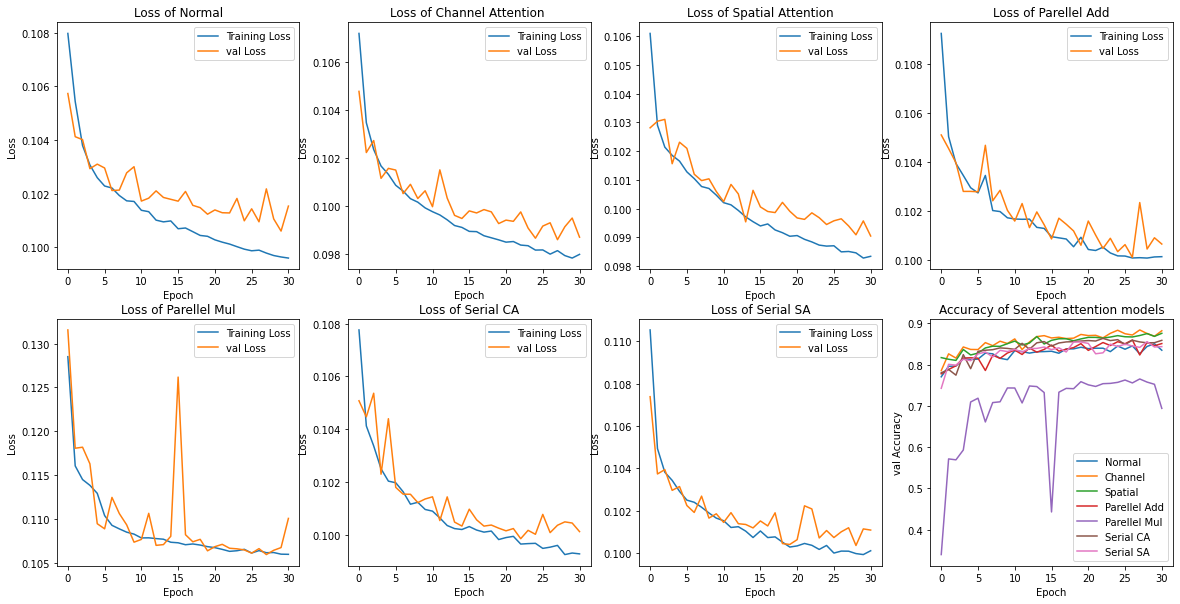

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(2,4,1)
plt.plot(model_normal_train_loss)
plt.plot(model_normal_val_loss)
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,2)
plt.plot(model_channel_train_loss)
plt.plot(model_channel_val_loss)
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,3)
plt.plot(model_spatial_train_loss)
plt.plot(model_spatial_val_loss)
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,4)
plt.plot(model_parellel_add_train_loss)
plt.plot(model_parellel_add_val_loss)
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,5)
plt.plot(model_parellel_mul_train_loss)
plt.plot(model_parellel_mul_val_loss)
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,6)
plt.plot(model_serial_ca_train_loss)
plt.plot(model_serial_ca_val_loss)
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,7)
plt.plot(model_serial_sa_train_loss)
plt.plot(model_serial_sa_val_loss)
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'val Loss'], loc=0)

plt.subplot(2,4,8)
plt.plot(model_normal_val_accuracy)
plt.plot(model_channel_val_accuracy)
plt.plot(model_spatial_val_accuracy)
plt.plot(model_parellel_add_val_accuracy)
plt.plot(model_parellel_mul_val_accuracy)
plt.plot(model_serial_ca_val_accuracy)
plt.plot(model_serial_sa_val_accuracy)

plt.title('Accuracy of Several attention models')
plt.ylabel('val Accuracy')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel', 'Spatial', 'Parellel Add', 'Parellel Mul', 'Serial CA', 'Serial SA'], loc=0)

plt.show()